In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import timeit
from time import sleep
import cv2.aruco as aruco
import math
from IPython.display import display, clear_output

import math, sys, os
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from plotter import *
from kalman import *
from motion import *
from timer import *
from global_utils import convert_to_np,sort_coords,vis_graph,heuristic,a_star,plot_map,swap_xy
from vision_utils import *

In [2]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [3]:
%%run_python

state = 1

@onevent
def move(speed_left, speed_right):
    global motor_left_target, motor_right_target, state
    if state == 1 :
        motor_left_target = speed_left
        motor_right_target = speed_right
    
@onevent 
def button_center():
    global state, motor_left_target, motor_right_target
    state = 0
    motor_left_target = 0
    motor_right_target = 0

In [4]:
def send_command():
    if command[step][0] == command[step][1] and command[step][0] != 0:
        send_event("move", command[step][0] + 2, command[step][1] - 2)
    else :
        send_event("move", command[step][0], command[step][1])

In [5]:
@tdmclient.notebook.sync_var
def get_speed():
    return motor_left_speed, motor_right_speed

def kalman_call():
    global step, x_est, P_est, rt, camera_pos, cam_OK
    if step < len(command) :
        #retrieves the command that was applied Ts seconds ago
        speed_left = command[step][0]
        speed_right = command[step][1]
        
        #gets the right matrix corresponding to the command :
        #Thymio goes forward
        if speed_left == speed_right :
            A = A_F

        #Thymio is rotating
        else :
            A = A_R
            
        #measures the speed of the robot
        meas_speed_left,  meas_speed_right = get_speed()
        
        #get the last measured position
        meas_pos = camera_pos
            

        #computes the estimated states
        new_x_est, new_P_est = kalman_filter(meas_pos, meas_speed_left, meas_speed_right, x_est, P_est, A, cam_OK)

        x_est = new_x_est
        P_est = new_P_est
        
        step += 1
        
        if step < len(command) :
            send_command()
    else :
        rt.stop()

## Dynamic plotting in main loop

In [6]:
thymio_icon = cv2.imread('Thymio.jpg')
thymio_icon = cv2.cvtColor(thymio_icon, cv2.COLOR_RGB2BGR)
def vision_update(): #40ms cycle
    global cap, frame, cam_OK, img_out, camera_pos,x_est,\
           Thymio_center, Thymio_dir, Thymio_target,\
           warpedimg_clean_annotated, warpedimg_annotated
    ret, frame_tmp = cap.read()
    if ret:
        frame = cv2.cvtColor(frame_tmp, cv2.COLOR_BGR2RGB)
#     frame = cv2.cvtColor(frame_tmp, cv2.COLOR_BGR2RGB)
#     warpedimg = frame
#     warpedimg_clean = frame
#     frame = cv2.cvtColor(frame_tmp, cv2.COLOR_BGR2RGB)
    cam_OK, Thymio_center_tmp, Thymio_dir_tmp, warpedimg_tmp = localisation_cam(frame)
    if cam_OK:
        Thymio_center, Thymio_dir, warpedimg = Thymio_center_tmp, Thymio_dir_tmp, warpedimg_tmp
        warpedimg_annotated = overlay_vis_graph([int(Thymio_start[0]),int(Thymio_start[1])],[int(x_est[0][0]),int(x_est[1][0])], [int(Thymio_target[0]),int(Thymio_target[1])], obs_corners, optimal_path, warpedimg)
        camera_pos = np.array(Thymio_center + [Thymio_dir]).reshape(3,1)
    warpedimg_clean = merge_img(img_out, rotate_image(thymio_icon,x_est[2][0]), int(x_est[0][0])-120, int(x_est[0][0])+120, int(x_est[1][0])-120, int(x_est[1][0])+120)[:,:,0:3]
    warpedimg_clean_annotated = overlay_vis_graph([int(Thymio_start[0]),int(Thymio_start[1])],[int(x_est[0][0]),int(x_est[1][0])], [int(Thymio_target[0]),int(Thymio_target[1])], obs_corners, optimal_path, warpedimg_clean)

Unchecked ExtSlice(dims=[Slice(lower=None, upper=None, step=None), Slice(lower=None, upper=None, step=None), Slice(lower=Constant(value=0, kind=None), upper=Constant(value=3, kind=None), step=None)])


In [7]:
#setup camera
cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_EXPOSURE, -4)  #adjust this to avoid reflection from A4 paper

True

In [8]:
ret, frame = cap.read()
sleep(1)
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

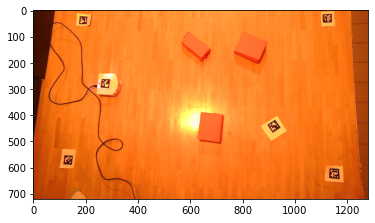

In [9]:
plt.imshow(frame)

In [9]:
cam_OK, Thymio_start, Thymio_dir, Thymio_target, obs_corners, obstacles_mask, img_out = localisation_cam_all(frame)

In [10]:
cam_OK

False

In [11]:
#camera warmup run at start up to get stable frames

ret, frame = cap.read()
while(not ret):
    cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
sleep(1)
ret, frame = cap.read()
while(not ret):
    cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#run one time or when replanning
cam_OK, Thymio_start, Thymio_dir, Thymio_target, obs_corners, obstacles_mask, img_out = localisation_cam_all(frame)
[obs_coords, start, goal] = convert_to_np(obs_corners, Thymio_start, Thymio_target)
obs_coords = sort_coords(obs_coords)
[nodes, edges] = vis_graph(obs_coords, start, goal)
h = heuristic(nodes)
optimal_path = a_star(nodes, edges, h)
Thymio_center = Thymio_start

cam_OK, Thymio_center_tmp, Thymio_dir_tmp, warpedimg_tmp = localisation_cam(frame)
Thymio_center, Thymio_dir, warpedimg = Thymio_center_tmp, Thymio_dir_tmp, warpedimg_tmp
warpedimg_clean = merge_img(img_out, rotate_image(thymio_icon,Thymio_dir), int(Thymio_center[0])-120, int(Thymio_center[0])+120, int(Thymio_center[1])-120, int(Thymio_center[1])+120)[:,:,0:3]
warpedimg_clean_annotated = overlay_vis_graph([int(Thymio_start[0]),int(Thymio_start[1])],[int(Thymio_center[0]),int(Thymio_center[1])], [int(Thymio_target[0]),int(Thymio_target[1])], obs_corners, optimal_path, warpedimg_clean)
warpedimg_annotated = overlay_vis_graph([int(Thymio_start[0]),int(Thymio_start[1])],[int(Thymio_center[0]),int(Thymio_center[1])], [int(Thymio_target[0]),int(Thymio_target[1])], obs_corners, optimal_path, warpedimg)
camera_pos = np.array(Thymio_center+[Thymio_dir]).reshape(3,1)
# print(cam_OK)

#initial unknown state :
x0 = 0
y0 = 0
theta0 = 0

x_dot0 = 0 
y_dot0 = 0
theta_dot0 = 0 

x_est = np.array([[x0], [y0], [theta0], [x_dot0], [y_dot0], [theta_dot0]])
P_est = 1000 * np.diag(np.ones(6))

Unchecked ExtSlice(dims=[Slice(lower=None, upper=None, step=None), Slice(lower=None, upper=None, step=None), Slice(lower=Constant(value=0, kind=None), upper=Constant(value=3, kind=None), step=None)])


error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'polylines'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'


In [51]:
plt.imshow(frame)

In [46]:
optimal_path

[[1, array([371.75,  91.  ])],
 [2, array([429, 647], dtype=int32)],
 [3, array([454, 833], dtype=int32)],
 [17, array([ 532.25, 1026.75])]]

In [47]:
#start vision update
rt1 = RepeatedTimer(0.05, vision_update)

step = 0
command = move_forward(860) + turn_right(math.pi/2) + move_forward(130) + [[0, 0]]

#start Kalman
send_command()
rt = RepeatedTimer(Ts, kalman_call)

[[0]
 [0]
 [0]]
[[0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]]
[[371.74070706]
 [ 88.98398388]
 [ 93.71370467]]
[[371.74070706]
 [ 88.98398388]
 [ 93.71370467]]
[[371.74274897]
 [ 88.98447263]
 [ 93.71370467]]
[[371.74274897]
 [ 88.98447263]
 [ 93.71370467]]
[[371.74274897]
 [ 88.98447263]
 [ 93.71370467]]
[[371.74810466]
 [ 89.67575591]
 [ 93.72309175]]
[[371.74810466]
 [ 89.67575591]
 [ 93.72309175]]


In [48]:
%matplotlib qt
fig = plt.figure(figsize=(12,20))
ax1 = fig.add_subplot(5,1,1)
ax2 = fig.add_subplot(5,1,2)
ax3 = fig.add_subplot(5,1,3)
ax4 = fig.add_subplot(5,1,4)
ax5 = fig.add_subplot(5,1,5)

while(1):
    ax4.cla()
    ax4.imshow(warpedimg_clean_annotated)
    ax5.cla()
    ax5.imshow(warpedimg_annotated)
    plt.pause(0.001)
    clear_output(wait=True)
    if step < len(command):
        plot(ax1, ax2, ax3, x_est, P_est, fig)
#     print(x_est[-1][:3])
    #time.sleep(0.1)

[[372.01448141]
 [ 89.34774209]
 [ 93.28642148]]
[[372.01448141]
 [ 89.34774209]
 [ 93.28642148]]
[[372.01448141]
 [ 89.34774209]
 [ 93.28642148]]
[[372.01448141]
 [ 89.34774209]
 [ 93.28642148]]
[[372.17430896]
 [ 89.22779157]
 [ 93.22917782]]
[[372.17430896]
 [ 89.22779157]
 [ 93.22917782]]
[[372.17430896]
 [ 89.22779157]
 [ 93.22917782]]


KeyboardInterrupt: 

[[372.22188063]
 [ 89.46629491]
 [ 93.13935372]]


In [49]:
rt1.stop()


[[372.14663996]
 [ 89.29925882]
 [ 93.01521283]]
[[372.14663996]
 [ 89.29925882]
 [ 93.01521283]]
[[372.14663996]
 [ 89.29925882]
 [ 93.01521283]]
[[371.94806643]
 [ 89.22279806]
 [ 93.10079291]]
[[371.85210077]
 [ 89.1693559 ]
 [ 93.18185532]]
[[371.80305332]
 [ 89.13018178]
 [ 93.25656862]]
[[371.77762642]
 [ 89.10072695]
 [ 93.32358891]]
[[371.76439423]
 [ 89.07824237]
 [ 93.38249359]]
[[371.75750102]
 [ 89.06092056]
 [ 93.43352646]]
[[371.75390905]
 [ 89.0475015 ]
 [ 93.47730252]]
[[371.75203717]
 [ 89.0370705 ]
 [ 93.51459757]]
[[371.75106166]
 [ 89.02894541]
 [ 93.54622119]]
[[371.75055328]
 [ 89.02260847]
 [ 93.57294793]]
[[371.75028834]
 [ 89.01766233]
 [ 93.59548449]]
[[371.75015026]
 [ 89.01379994]
 [ 93.61445744]]
[[371.75007831]
 [ 89.01078297]
 [ 93.63041242]]
[[371.75004081]
 [ 89.00842595]
 [ 93.64381896]]
[[371.75002127]
 [ 89.00658433]
 [ 93.65507791]]
[[371.75001108]
 [ 89.0051453 ]
 [ 93.66452962]]
[[371.75000578]
 [ 89.00402082]
 [ 93.67246204]]
[[371.75000301]
 [ 

In [20]:
ret, frame = cap.read()

In [21]:
ret

True

In [22]:
plt.imshow(frame)

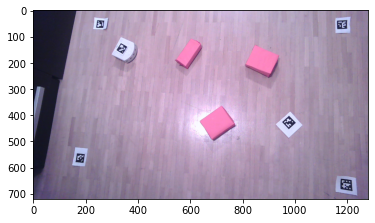

In [8]:
#for faking dynamic camera input
frame_tmp = cv2.imread('test3.png')
frame = cv2.cvtColor(frame_tmp, cv2.COLOR_BGR2RGB)
# frame = cv2.imread('test_im_floor.jpeg')
plt.imshow(frame)

In [12]:
%matplotlib qt
# %matplotlib inline #not working
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
while(1):
    ax1.cla()
    ax1.imshow(warpedimg_clean_annotated)
    ax2.cla()
    ax2.imshow(warpedimg_annotated)
    plt.pause(0.001)
    clear_output(wait=True)

KeyboardInterrupt: 